# Velo Antwerpen

In [1]:
import folium

print (folium.__version__)

0.5.0


In [ ]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import *
from datetime import datetime

# 151 stations
# 28788 CustID's
# header = 'BikeLocationID BikeID CityID SlotID StationID CentreCode CustID EmployeeID LocationType \
# BikeLocationDate PassType PassNumber LocationCreationDate LocationUpdateDate LocationCreationLogin \
# LocationUpdateLogin LocationIsBroken LocationExpired LocationLength LocationFreeMinutes LocationIsInvoiced \
# LocationReleaseDate LocationLengthInSeconds Expr1 Expr2'

MONTHS = ['january','february','march','april','may','june','july','august','september','october','november']
bike_data = []
sc = SparkContext.getOrCreate()
sqlContext = SQLContext.getOrCreate(sc=sc)

# layout : id;objectid;lat;lng;obj_type;type;o_id;
# naam;aantal_loc;ligging;orientatie;status;shape


def make_station_dict(data):
    station_dict = {}
    station_lines = data.collect()
    for line in station_lines:
        line = line.replace('"', '')
        all_vals = line.split(';')
        # key = station_nr, value = name, slots, lat, lng
        station_dict[int(all_vals[6])] = [all_vals[7], int(all_vals[8]), 
                                              float(all_vals[2]), float(all_vals[3])]
    return station_dict


station_data = (sc.textFile(name='./Velo_Archive/velostation.csv').filter(lambda l: 'objectid' not in l)).cache()
s = make_station_dict(station_data)
# append missing station data
s[13] = ['De Singel', 36, 51.193854, 4.402448]
s[38] = ['Pastorijstraat', 21, 51.220099, 4.432667]
s[62] = ['Station Dam', 24, 51.231768, 4.426996]
s[63] = ['Slachthuis', 36, 51.230044, 4.431642]
s[73] = ['Maarschalk Gerard', 36, 51.212237, 4.403704]
station_dict = sc.broadcast(s)


def add_fields(line, separator):
    fields = []
    vals = line.split(separator)
    # bike id
    fields.append(int(vals[1]))
    # day
    if '.' in vals[9]:
        date = datetime.strptime(vals[9][:-4], '%Y-%m-%d %H:%M:%S')
    else:
        date = datetime.strptime(vals[9], '%Y-%m-%d %H:%M:%S')
    fields.append(date.day)
    # month
    fields.append(date.month)
    # weekend
    if date.weekday() == 5 or date.weekday() == 6:
        fields.append(1)
    else:
        fields.append(0)
    # hour
    fields.append(date.hour)
    # minute
    fields.append(date.minute)
    try:
        # station ID
        fields.append(int(vals[4]))
        # station data
        sd = station_dict.value
        e = []
        d = sd[int(vals[4])]
        e.append(str(d[0]))
        e.append(int(d[1]))
        e.append(float(d[2]))
        e.append(float(d[3]))
        fields.extend(e)
    except:
        fields.extend([-1, 'Unknown', 0, 0.0, 0.0])
    # location length
    try:
        fields.append(float(vals[18]))
    except:
        fields.append(0.0)
    # location type
    fields.append(vals[8])
    
    return fields


# convert to a dataframe
def convert_to_df(month):
    if month == '2015-01':
        separator = '\t'
    else:
        separator = ';'
    
    month_data = sc.textFile(name='./Velo_Archive/' + month + '.csv.gz')
    month_rdd = (month_data
                    .filter(lambda l: 'BikeLocationID' not in l)
                    .map(lambda l: add_fields(l, separator))
                    .filter(lambda l: len(l) == 13))
    
    # apply the schema to the RDD.
    month_df = sqlContext.createDataFrame(month_rdd, schema)
    
    return month_df

fields = []
fields.append(StructField('bike_id', IntegerType(), True))
fields.append(StructField('day', IntegerType(), True))
fields.append(StructField('month', IntegerType(), True))
fields.append(StructField('weekend', IntegerType(), True))
fields.append(StructField('hour', IntegerType(), True))
fields.append(StructField('minute', IntegerType(), True))
fields.append(StructField('station_id', IntegerType(), True))
fields.append(StructField('station_name', StringType(), True))
fields.append(StructField('slots', IntegerType(), True))
fields.append(StructField('lat', FloatType(), True))
fields.append(StructField('lng', FloatType(), True))
fields.append(StructField('location_length', FloatType(), True))
fields.append(StructField('location_type', StringType(), True))
schema = StructType(fields)

print('Loading data...')
for i in range(1, 12):
    print('loading ' + str(i))
    try:
        month = '2015-' + str(i).zfill(2)
        convert_to_df(month).registerTempTable(MONTHS[i - 1] + '_table')
        sql = 'SELECT COUNT(*) AS CNT, SUM(location_length) AS SUM FROM ' + MONTHS[i - 1] + '_table WHERE location_type = \'A\''
        bike_data.append(sqlContext.sql(sql).collect())
        print ('pass')
    except Exception as e:
        bike_data.append(None)
        print ('fail')
print ('Data loaded')

## Monthly data

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

x_axis = [i+1 for i in range(11)]
y_axis = []

for i in range(11):
    try:
        y_axis.append(bike_data[i][0]['CNT'])
    except:
        y_axis.append(0)

fig = plt.figure(figsize=(7, 7))
fig.suptitle('Trips per month', fontsize=14)
ax = fig.add_subplot(111)
ax.set_xlabel('month')
ax.set_ylabel('rentals')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

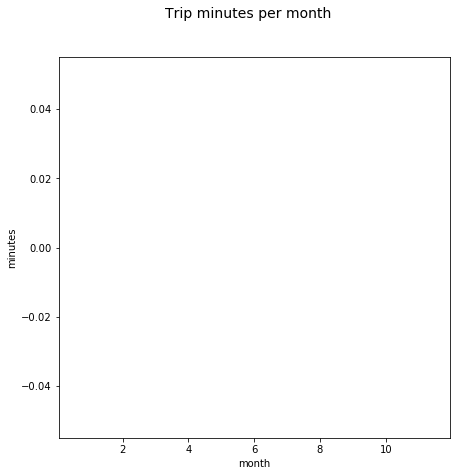

In [5]:
y_axis = []

for i in range(11):
    try:
        y_axis.append(bike_data[i][0]['SUM'])
    except:
        y_axis.append(0)

fig = plt.figure(figsize=(7, 7))
fig.suptitle('Trip minutes per month', fontsize=14)
ax = fig.add_subplot(111)
ax.set_xlabel('month')
ax.set_ylabel('minutes')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

## Totals and Averages

In [ ]:
total_trips = 0
total_minutes = 0

for i in range(11):
    try:
        total_trips += bike_data[i][0]['CNT']
        total_minutes += bike_data[i][0]['SUM']
    except:
        pass
    
print ('Total trips : %.2f' % round(total_trips / 11, 2))
print ('Total minutes : %.2f min' % round(total_minutes / 11, 2))
print ('Average rent time : %.2f min' % round(total_minutes / total_trips, 2))

In [6]:
for month in MONTHS:
    try:
        print ('Average rent time ' + month + ' : %.2f min' 
           % round(sqlContext.sql('SELECT AVG(location_length) FROM ' + month + '_table \
                                               WHERE location_type = \'A\'').collect()[0][0], 2))
    except:
        pass

## Difference between arrivals and departures per station

In [ ]:
def convert_row(row):
    try:
        return [int(row.station_id), row.arrivals - row.departures]
    except:
        pass

def make_station_data(month):
    sql_str = 'SELECT station_id, \
        sum(case when location_type = \'A\' then 1 else 0 end) as arrivals, \
        sum(case when location_type = \'R\' then 1 else 0 end) as departures \
        FROM ' + month + '_table group by station_id'

    return sqlContext.sql(sql_str).rdd.map(lambda r: convert_row(r)).collect()

In [7]:
from IPython.display import HTML
import folium

month = 9
totals = make_station_data(MONTHS[month - 1])

def create_map(m, height=650, title=''):
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML(title + '<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

m = folium.Map(location=[51.217098, 4.417978], zoom_start=13)
sd = station_dict.value

for total in totals:
    try:
        station = sd[int(total[0])]
        if total[1] >= 0:
            c = 'mediumseagreen'
        else:
            c = 'tomato'
        r = abs(total[1]) / 6
        p = station[0] + ' : ' + str(total[1])
        m.circle_marker(location=[station[2], station[3]], radius=r,
                    popup=p, line_color=c, fill_color=c)
    except:
        pass

create_map(m)

NameError: name 'make_station_data' is not defined

In [ ]:
month = 9

sql_str = 'SELECT a.day, a.month, a.hour, a.station_id as id1, b.station_id as id2, \
            a.location_type as type1, b.location_type as type2 \
            FROM ' + MONTHS[month - 1] + '_table a \
            INNER JOIN ' + MONTHS[month - 1] + '_table b \
            ON (a.bike_id=b.bike_id AND a.day=b.day AND a.month=b.month AND a.hour=b.hour) \
            WHERE a.location_type=\'R\' AND b.location_type=\'A\' \
            OR a.location_type=\'A\' AND b.location_type=\'R\' \
            AND a.station_id<>b.station_id'
            #AND a.weekend=0'

all_trips = sqlContext.sql(sql_str).rdd.map(lambda r: (r.day, r.month, r.hour, r.id1, r.id2, r.type1, r.type2))
all_trips.cache()
pass

In [ ]:
week_day = 9
weekend_day = 13

hours = [x for x in range(0, 24)]
week_trips = []
weekend_trips = []

for x in range(0, 24):
    week_trips.append(all_trips.filter(lambda tup: tup[0] == week_day and tup[1] == month and tup[2] == x).count())

for x in range(0, 24):
    weekend_trips.append(all_trips.filter(lambda tup: tup[0] == weekend_day and tup[1] == month and tup[2] == x).count())

fig = plt.figure(figsize=(15, 5))
plt1 = fig.add_subplot(121)
fig.suptitle('Trips per hour for ' + str(week_day) + '/' + str(month)
                     + ' and ' + str(weekend_day) + '/' + str(month), fontsize=14)
plt1.plot(hours, week_trips)
plt2 = fig.add_subplot(122)
plt2.plot(hours, weekend_trips)
pass

In [ ]:
def show_trips(day, month, hour, threshold=5):
    trip_dict = {}
    dep_arr_dict = {}
    departure_dict = {}
    sd = station_dict.value
    trips = all_trips.filter(lambda tup: tup[0] == day 
                                     and tup[1] == month 
                                     and tup[2] == hour).collect()
    
    m = folium.Map(location=[51.217098, 4.417978], zoom_start=13)
    
    for trip in trips:
        key1 = str(trip[3]) + '-' + str(trip[4])
        key2 = str(trip[4]) + '-' + str(trip[3])
        if key1 in trip_dict:
            trip_dict[key1] += 1
        elif key2 in trip_dict:
            trip_dict[key2] += 1
        else:
            trip_dict[key1] = 1
        
        if trip[5] == 'A' and trip[6] == 'R':
            if trip[3] in dep_arr_dict:
                dep_arr_dict[trip[3]] += 1
            else:
                dep_arr_dict[trip[3]] = 1
                
            if trip[4] in dep_arr_dict:
                dep_arr_dict[trip[4]] -= 1
            else:
                dep_arr_dict[trip[4]] = -1
        elif trip[5] == 'R' and trip[6] == 'A':
            if trip[3] in dep_arr_dict:
                dep_arr_dict[trip[3]] -= 1
            else:
                dep_arr_dict[trip[3]] = -1
                
            if trip[4] in dep_arr_dict:
                dep_arr_dict[trip[4]] += 1
            else:
                dep_arr_dict[trip[4]] = 1
        
    for trip in trip_dict.items():
        size = int(trip[1])
        stats = trip[0].split('-')
        stat1 = int(stats[0])
        stat2 = int(stats[1])
        if size > threshold and stat1 != stat2:
            coords = []
            coords.append([sd[stat1][2], sd[stat1][3]])
            coords.append([sd[stat2][2], sd[stat2][3]])
            
            if dep_arr_dict[stat1] >= 0:
                c1 = 'mediumseagreen'
            else:
                c1 = 'tomato'

            r1 = abs(dep_arr_dict[stat1])
            p1 = sd[stat1][0] + ' : ' + str(dep_arr_dict[stat1])
            m.circle_marker(location=[sd[stat1][2], sd[stat1][3]], radius=r1,
                            popup=p1, line_color=c1, fill_color=c1)

            if dep_arr_dict[stat2] >= 0:
                c2 = 'mediumseagreen'
            else:
                c2 = 'tomato'
                
            r2 = abs(dep_arr_dict[stat2])
            p2 = sd[stat2][0] + ' : ' + str(dep_arr_dict[stat2])
            m.circle_marker(location=[sd[stat2][2], sd[stat2][3]], radius=r2,
                            popup=p2, line_color=c2, fill_color=c2)
            
            p = str(size) + ' trip'
            if size > 1:
                p += 's'
            c = 'steelblue'
            m.line(coords, popup=p, line_color=c, line_weight=size/2)
    
    if int(inp_hour) < 12:
        title = '<h3>' + inp_hour + ' - ' + str(int(inp_hour) + 1) + ' AM' + '</h3><br/>'
    else:
        title = '<h3>' + inp_hour + ' - ' + str(int(inp_hour) + 1) + ' PM' + '</h3><br/>'
        
    return create_map(m, 650, title)

In [5]:
from IPython.display import HTML

form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Hour : <input id='hour' type='range' min='3' max='23' step='1' value='4' onchange='set_vars()'/>
Threshold : <input id='threshold' type='range' min='0' max='20' step='1' value='0' onchange='set_vars()'
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var var_name1 = 'inp_hour';
        var var_name2 = 'inp_threshold'
        var var_value1 = document.getElementById('hour').value;
        var var_value2 = document.getElementById('threshold').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var command2 = var_name2 + " = '" + var_value2 + "'"; 
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        kernel.execute(command2);
        cell = IPython.notebook.get_cell(15);
        cell.execute();
        cell.focus_cell();
    }
</script>
"""

HTML(form + javascript)

In [24]:
show_trips(9, 9, int(inp_hour), int(inp_threshold))

NameError: name 'inp_hour' is not defined

In [25]:
def make_raw_dataset():
    sql_str = ''
    for i in range(0, 9):
        if i != 5:
            sql_str += 'SELECT station_id, day, ' + str(i) + ' as month, first(slots) as slots, \
                first(lat) as lat, first(lng) as lng, \
                sum(case when location_type = \'A\' then 1 else 0 end) as arrivals, \
                sum(case when location_type = \'R\' then 1 else 0 end) as departures \
                FROM ' + MONTHS[i] + '_table group by station_id, day \
                UNION '
            
    return sqlContext.sql(sql_str[:-6]) # strip off last 'UNION'

In [14]:
from pyspark.mllib.regression import LabeledPoint
import itertools
import math

total_data = (make_raw_dataset().map(lambda row: LabeledPoint(row.arrivals, 
                    [row.day, row.month, row.slots, row.lat, row.lng, row.departures])))

weights = [.8, .2]
seed = 42
train_data, test_data = total_data.randomSplit(weights, seed)
train_data.cache()
#val_data.cache()
test_data.cache()
nTrain = train_data.count()
#nVal = val_data.count()
nTest = test_data.count()

#print 'Training data : ' + str(nTrain)
#print 'Test data : ' +  str(nTest)



NameError: name 'months' is not defined